In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [8]:
expers_to_load = [# Meta V1 model regressionT
                  (True, "run_20170828_19_50_27_metaV1_50ep_50ops_lr5e05"), # 50ops
                  # Stick-breaking V3.2 model
                  (True, "run_20170829_13_55_18_act_sbV3.2_50ep_nu0.5_lr5e05"), #
                  (True, "run_20170829_14_14_25_act_sbV3.2_50ep_nu0.95_lr5e05"), # 
                  # base act_sbV1
                  (True, "run_20170829_13_45_43_act_sbV1_100ep_nu0.5_lr5e05"), # with cost annealing until 1.
                  (True, "run_20170829_14_04_27_act_sbV1_100ep_nu0.95_lr5e05"), # with cost annealing unitl 0.5
                  # Graves ACT
                  (True, "run_20170829_15_39_38_act_gravesV1_50ep_tau0.0008_lr5e05")]



In [9]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 200

without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger


INFO - created local logger for experiment with model metaV1_regression_T_50ops
INFO - INFO - loaded existing model from file logs/run_20170828_19_50_27_metaV1_50ep_50ops_lr5e05/metaV1_regression_T_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model act_sbV3.2_regression_T_nu0.5
INFO - INFO - loaded existing model from file logs/run_20170829_13_55_18_act_sbV3.2_50ep_nu0.5_lr5e05/act_sbV3.2_regression_T_nu0.5.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'l

0 Loading model metaV1_regression_T_50ops / run_20170828_19_50_27_metaV1_50ep_50ops_lr5e05
1 Loading model act_sbV3.2_regression_T_nu0.5 (q-prob 0.50) / run_20170829_13_55_18_act_sbV3.2_50ep_nu0.5_lr5e05
2 Loading model act_sbV3.2_regression_T_nu0.95 (q-prob 0.95) / run_20170829_14_14_25_act_sbV3.2_50ep_nu0.95_lr5e05
3 Loading model act_sbV1_regression_T_nu0.5 (q-prob 0.50) / run_20170829_13_45_43_act_sbV1_100ep_nu0.5_lr5e05
4 Loading model act_sbV1_regression_T_nu0.95 (q-prob 0.95) / run_20170829_14_04_27_act_sbV1_100ep_nu0.95_lr5e05
5 Loading model act_gravesV1_regression_T_tau0.0008 (q-prob 0.90) / run_20170829_15_39_38_act_gravesV1_50ep_tau0.0008_lr5e05


In [5]:
del new_experiments
new_experiments = []


for exper in expers_to_load:
    if exper[0]:
        print("Loading experiment {}".format(exper[1]))
        new_experiments.append(Experiment.load(path_to_exp=exper[1] + "/" + 
                                               "exp_eval_stats_10000_" + str(MAX_EVAL_STEPS) +"steps.dll",
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170828_19_50_27_metaV1_50ep_50ops_lr5e05
Loading experiment run_20170829_13_55_18_act_sbV3.2_50ep_nu0.5_lr5e05
Loading experiment run_20170829_14_14_25_act_sbV3.2_50ep_nu0.95_lr5e05
Loading experiment run_20170829_13_45_43_act_sbV1_100ep_nu0.5_lr5e05
Loading experiment run_20170829_14_04_27_act_sbV1_100ep_nu0.95_lr5e05
Ready


In [10]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10reg_T_metaV1_act_sbV1_act_sbV3.2_1_200.png


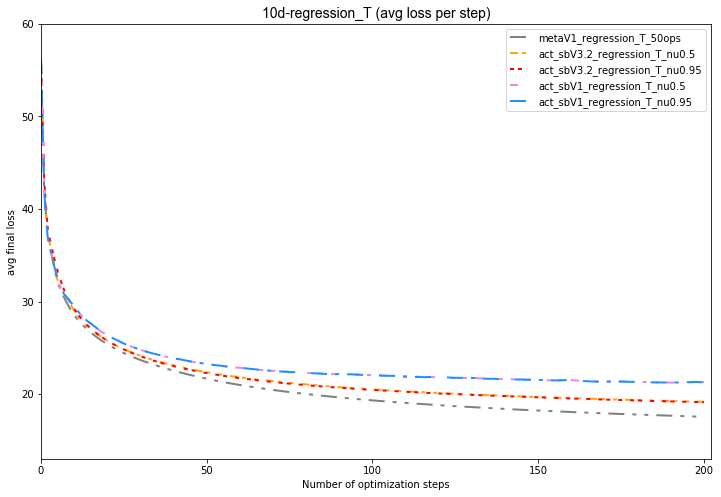

In [14]:
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10reg_T_metaV1_act_sbV1_act_sbV3.2_1_200", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=200,
                                              sort_exper="10d-regression_T",
                                              log_scale=False,
                                              # y_lim=[9, 66],
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.9_08:58:01.png


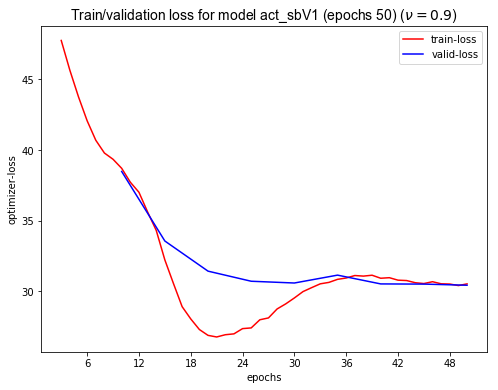

In [5]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [11]:
exp_idx = 5
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_gravesV1_regression_T_tau0.0008 with q-prob 0.900


INFO - ! - Validation last step 181 - !
INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 56.32   43.276  38.587  37.031  35.289  33.878  32.767  31.784  31.021
  30.362  29.813  29.312  28.852  28.429  28.043  27.685  27.359  27.06
  26.784  26.523  26.276  26.039  25.819  25.613  25.42   25.24   25.067
  24.904  24.744  24.594  24.449  24.313  24.181  24.055  23.934  23.819
  23.708  23.601  23.5    23.404  23.308  23.216  23.125  23.039  22.957
  22.878  22.804  22.731  22.66   22.592  22.526  22.464  22.402  22.343
  22.283  22.221  22.164  22.108  22.054  22.001  21.95   21.902  21.854
  21.808  21.764  21.72   21.677  21.634  21.594  21.554  21.512  21.474
  21.436  21.399  21.365  21.333  21.298  21.266  21.234  21.205  21.175
  21.145  21.117  21.088  21.062  21.036  21.009  20.982  20.955  20.931
  20.904  20.881  20.856  20.832  20.809  20.787  20.767  20.743  20.723
  20.7    20.68   20.66   20.641  20.621  20.601  20.582  20.562  20.544
  20.527  20.509  20.

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [5]:
exp_idx = 0
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_T_50ops with 10000 functions


Validating model metaV1_regression_T_50ops with q-prob 0.900


INFO - INFO - Epoch 400, elapsed time 8.13 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 4.187e+03/17.54/6.088
INFO - INFO - Epoch 400: Final step losses: [ 56.32   42.028  37.141  35.407  33.649  32.111  31.136  30.411  29.719
  29.057  28.528  28.092  27.695  27.315  26.972  26.662  26.373  26.1
  25.845  25.609  25.383  25.172  24.975  24.785  24.605  24.432  24.265
  24.109  23.959  23.815  23.677  23.546  23.418  23.293  23.174  23.058
  22.944  22.833  22.73   22.629  22.529  22.433  22.336  22.241  22.15
  22.062  21.978  21.893  21.81   21.73   21.653  21.577  21.503  21.43
  21.359  21.291  21.225  21.162  21.1    21.038  20.979  20.92   20.862
  20.806  20.751  20.697  20.644  20.593  20.542  20.492  20.443  20.392
  20.343  20.295  20.249  20.205  20.163  20.121  20.079  20.038  19.998
  19.96   19.922  19.884  19.846  19.809  19.772  19.735  19.701  19.666
  19.631  19.597  19.563  19.53   19.497  19.465  19

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


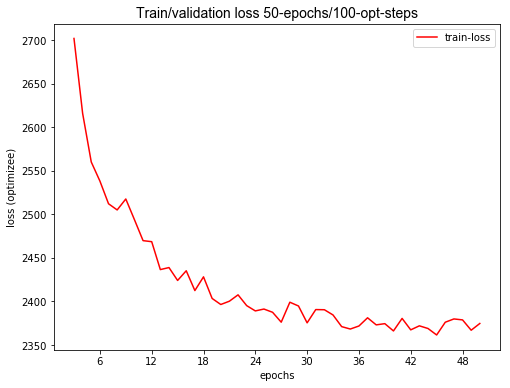

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


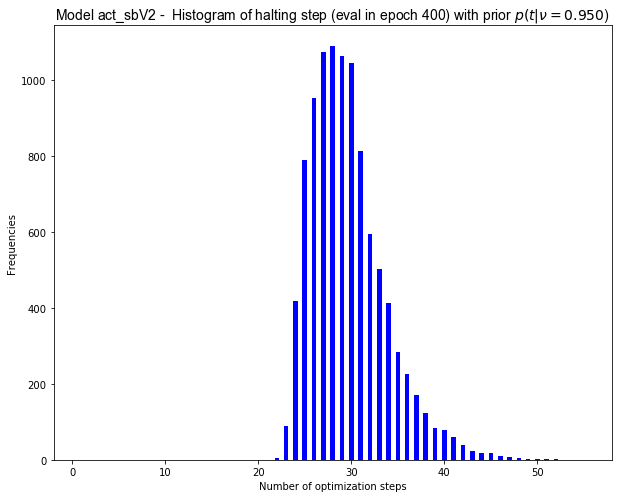

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

INFO - Successfully saved fig logs/run_20170829_15_39_38_act_gravesV1_50ep_tau0.0008_lr5e05/halting_step_versus_nll_distance.png


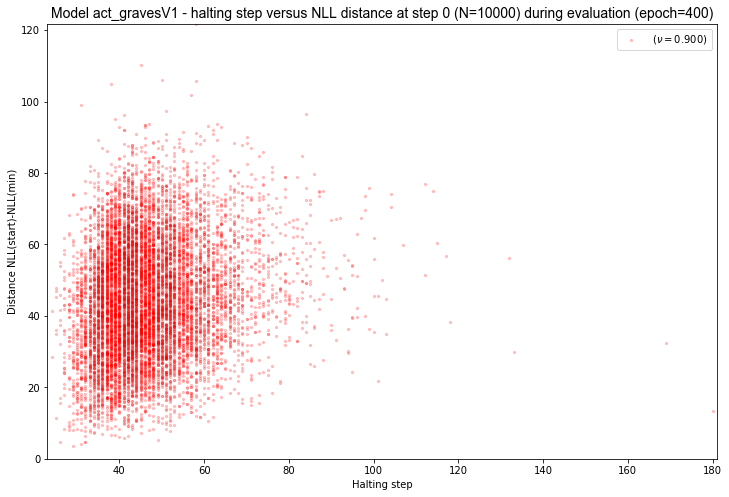

In [12]:
plot_loss_versus_halting_step(new_experiments[5], epoch=400, do_show=True, do_save=True)

In [47]:
new_experiments[3].val_stats["halt_step_funcs"][400]

array([ 41.,  51.,  36., ...,  51.,  58.,  45.], dtype=float32)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [11]:
experiments[3].generate_figures()

INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/eval_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_qts_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_halting_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/qt_values_train_act_sbV1_50ep_nu0.